# Google News

In [39]:
from GoogleNews import GoogleNews
import pandas as pd
import re
import unicodedata
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option('display.max_columns', None)

In [40]:
googlenews = GoogleNews(period="1d", encode='utf-8')#lang='fr'

In [43]:
googlenews.clear()
googlenews.get_news('BITCOIN')

In [44]:
news = googlenews.results()
len(news)

93

In [45]:
news_df = pd.DataFrame()
for k in range(len(news)):
    news_line = pd.DataFrame(news[k], index=[k])
    news_df = pd.concat([news_df, news_line], axis=0)

In [46]:
news_df.sample(2)

,title,desc,date,datetime,link,img,media,site
19,Advisor to President of Colombia: Bitcoin Is '...,bookmark_border,21 hours ago,2021-08-21 16:12:24.407841,news.google.com/./articles/CBMifWh0dHBzOi8vd3d...,https://lh3.googleusercontent.com/proxy/CZVe_E...,None,CryptoGlobe
77,Assessing the odds of Uniswap recovering from ...,bookmark_border,16 hours ago,2021-08-21 21:12:24.420196,news.google.com/./articles/CAIiED4N25njyvNtsuh...,https://lh3.googleusercontent.com/proxy/uvZtTM...,None,AMBCrypto News


In [49]:
news_df["date"] = news_df["date"].apply(lambda x: float(x.replace("hours ago", "").replace("hour ago", "").replace("minutes ago", "").strip()))

In [50]:
news_df.sort_values(by="date", ascending=True)[0:2]

,title,desc,date,datetime,link,img,media,site
21,Cryptocurrency Companies Are Leaving China in ...,bookmark_border,1.0,2021-08-22 12:12:24.408259,news.google.com/./articles/CAIiENmNLviEqerHL-0...,https://lh3.googleusercontent.com/proxy/Z_2PFd...,None,The Wall Street Journal
34,"Bitcoin is approaching the $ 50,000 level … th...",bookmark_border,1.0,2021-08-22 12:12:24.411081,news.google.com/./articles/CAIiEJOPQGQGZczkpS4...,https://lh3.googleusercontent.com/proxy/X03OIe...,None,asumetech


In [51]:
news_df.loc[0].at["link"]

'news.google.com/./articles/CAIiEK_rkmiktCtx5IyinNdHsQIqGQgEKhAIACoHCAow4uzwCjCF3bsCMKrOrwM?hl=en-US&gl=US&ceid=US%3Aen'

# Imports

In [52]:
%matplotlib inline
import string
import numpy as np
import matplotlib
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

# Loading data

In [53]:
data_sentiment = pd.read_csv("../raw_data/stock_data.csv")
data_sentiment["Text"] = data_sentiment["Text"].apply(lambda x: x.strip())

In [54]:
data_sentiment["Sentiment"].value_counts()

 1    3685
-1    2106
Name: Sentiment, dtype: int64

In [55]:
data_sentiment.sample(5)

,Text,Sentiment
697,user Krisanti that is why I had mentioned that...,-1
3358,HN over 18 again doing above avg volume,1
406,AJ Over 18.00 on good volume,1
331,VVS Technicals are positive for a continued cl...,1
3381,BYD possible bounce zone,1


# Cleaning

In [56]:
def lowerize(df, label):
    """ text lowercase
        removes \n
        removes \t
        removes \r """
    df[label] = df[label].str.lower()
    df[label] = df[label].apply(lambda x: x.replace("\n", " "))
    df[label] = df[label].apply(lambda x: x.replace("\r", " "))
    df[label] = df[label].apply(lambda x: x.replace("\t", " "))
    return df

def remove_emails(df, label):
    """ This function removes email adresses
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])""", " ", x))
    return df

def remove_mentions(df, label):
    """ This function removes mentions (Twitter - starting with @) from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"@([a-zA-Z0-9_.-]{1,100})", " ", x))
    return df

def remove_hyperlinks(df, label):
    """ This function removes hyperlinks from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"http\S+", " ", x))
    return df

def remove_hashtags(df, label):
    """ This function removes hashtags
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"#\w+", " ", x))
    return df

def remove_html_tags(df, label):
    """ This function removes html tags from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"<.*?>", " ", x))
    return df

def remove_numbers(df, label):
    """ This function removes numbers from a text
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"\d+", " ", x))
    return df

def encode_unknown(df, label):
    """ This function encodes special caracters """
    df[label] = df[label].apply(lambda x: unicodedata.normalize("NFD", x).encode('ascii', 'ignore').decode("utf-8"))
    return df

def clean_punctuation_no_accent(df, label):
    """ This function removes punctuation and accented characters from texts in a dataframe 
        To be appplied to languages that have no accents, ex: english 
    """
    df[label] = df[label].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    return df

def remove_stop_words(text, stopwords=set(stopwords.words('english'))):
    """ This function removes stop words from a text
        inputs:
         - stopword list
         - text """

    # prepare new text
    text_splitted = text.split(" ")
    text_new = list()
    
    # stop words updated
    #stopwords = stopwords.union({"grocery store", "covid", "supermarket", "people", "grocery", "store", "price", "time"})
    
    # loop
    for word in text_splitted:
        if word not in stopwords:
            text_new.append(word)
    return " ".join(text_new)

def clean_stopwords(df, label):
    """ This function removes stopwords """
    df[label] = df[label].apply(lambda x: remove_stop_words(x))
    return df

def more_cleaning(df, label):
    """ This function
     1) removes remaining one-letter words and two letters words
     2) replaces multiple spaces by one single space
     3) drop empty lines """
    df[label] = df[label].apply(lambda x: re.sub(r'\b\w{1,2}\b', " ", x))
    df[label] = df[label].apply(lambda x: re.sub(r"[ \t]{2,}", " ", x))
    df[label] = df[label].apply(lambda x: x if len(x) != 1 else '')
    df[label] = df[label].apply(lambda x: np.nan if x == '' else x)
    df = df.dropna(subset=[label], axis=0).reset_index(drop=True).copy()
    return df

def lemmatize_one_text(text):
    """ This function lemmatizes words in text (it changes word to most close root word)
        inputs:
         - lemmatizer
         - text """

    # initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # tags
    lem_tags = ['a', 'r', 'n', 'v']

    # prepare new text
    text_splitted = text.split(" ")
    text_new = list()

    # change bool
    changed = ''
    
    # loop
    for word in text_splitted:
        changed = ''
        for tag in lem_tags:
            if lemmatizer.lemmatize(word, tag) != word:
                changed = tag
        if changed == '':
            text_new.append(word)
        else:
            text_new.append(lemmatizer.lemmatize(word, changed))

    return " ".join(text_new)

def lemmatize(df, label):
    """ This function lemmatizes texts """
    df[label] = df[label].apply(lambda x: lemmatize_one_text(x))
    return df

In [57]:
col_label = "TextClean"
df_train = data_sentiment.copy()
df_train[col_label] = data_sentiment["Text"]
df_train = lowerize(df_train, col_label)
df_train = remove_emails(df_train, col_label)
df_train = remove_mentions(df_train, col_label)
df_train = remove_hyperlinks(df_train, col_label)
df_train = remove_hashtags(df_train, col_label)
df_train = remove_html_tags(df_train, col_label)
df_train = remove_numbers(df_train, col_label)
df_train = encode_unknown(df_train, col_label)
df_train = clean_punctuation_no_accent(df_train, col_label)
df_train = clean_stopwords(df_train, col_label)
df_train = more_cleaning(df_train, col_label)
df_train = lemmatize(df_train, col_label)

In [58]:
df_train.sample(5)

,Text,Sentiment,TextClean
1992,OC more weakness here and it might hit a dime...,-1,weakness might hit dime
5062,The banks for years rode consumer spending and...,-1,bank year ride consumer spend borrow big profi...
2374,user: user O Stop loss in 41.54 after beating ...,1,user user stop loss beat
78,DNDN has broken through the clear 5.5 resistan...,1,dndn break clear resistanc level heavy volume ...
3393,AAP long 423 and under buying,1,aap long buy


# Evaluation: Bag Of Word VS TF-IDF vectorizer

In [59]:
y = df_train["Sentiment"]

## Bag of words

In [60]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df_train["TextClean"])
X_bow.toarray().shape

(5780, 6330)

In [61]:
nb_model = MultinomialNB()
cv_results = cross_validate(nb_model, X_bow, y, scoring="accuracy", cv=10)
cv_results["test_score"].mean()

0.7053633217993079

### N-Gram

In [62]:
tf_idf_vectorizer = TfidfVectorizer(ngram_range = (1, 1))
X_tfidf = tf_idf_vectorizer.fit_transform(df_train["TextClean"])
X_tfidf.toarray().shape

(5780, 6330)

In [63]:
#pd.DataFrame(X_tfidf.toarray(),columns = tf_idf_vectorizer.get_feature_names())

In [64]:
nb_model_tfidf = MultinomialNB()
cv_results_tfidf = cross_validate(nb_model_tfidf, X_tfidf, y, scoring="accuracy", cv=10)
cv_results_tfidf["test_score"].mean()

0.6899653979238753

<div style="font-size:20pt;color: royalblue">Bag of Words gives a better performance</div>

<b>For information</b>
```
vectorizer = CountVectorizer()
data_features = vectorizer.fit_transform(df_train["CleanText"])

tfidf_transformer = TfidfTransformer()
data_features_tfidf = tfidf_transformer.fit_transform(data_features)
X_tfidf = data_features_tfidf.toarray()
```
<b>Is equal to</b>

```
tf_idf_vectorizer = TfidfVectorizer(ngram_range = (1, 1))
X_tfidf = tf_idf_vectorizer.fit_transform(df_train["CleanText"])
```
<br><br><b>For information again, some possible parameters of CountVectorizer</b>
```
vectorizer = CountVectorizer(analyzer = "word", 
                             preprocessor = None, 
                             stop_words =  'english', 
                             max_features = 6000, ngram_range=(1,5))
```

In [65]:
# train test split tarabiscoté
np.random.seed(0)
test_index = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_index = list(set(range(len(y))) - set(test_index))

# X_train
train_data = X_tfidf[train_index,]

# y_train
train_labels = y[train_index]

# X_test
test_data = X_tfidf[test_index,]

# y_test
test_labels = y[test_index]

# Text blob

In [66]:
from textblob import TextBlob
#Create polarity function and subjectivity function
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
pol_list = [pol(x) for x in df_train["TextClean"]]
sub_list = [sub(x) for x in df_train["TextClean"]]

In [67]:
df_train["Polarity"] = pol_list
df_train["Subjectivity"] = sub_list

In [68]:
df_train.sample(2)

,Text,Sentiment,TextClean,Polarity,Subjectivity
3863,user: < Opens door for AAP deal with China Mo...,1,user open door aap deal china mobile sad build,-0.25,0.75
2524,M currently above resistance this morning,1,currently resistance morning,0.00,0.40


# Training with Stochastic Gradient Descent Classifier

In [69]:
from sklearn.linear_model import SGDClassifier
## Fit logistic classifier on training data
clf = SGDClassifier(loss="log", penalty="none")
clf.fit(train_data, train_labels)

## Pull out the parameters (w, b) of the logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_

## Get predictions on training and test data
preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))
print("Training error: ", float(errs_train)/len(train_labels))
print("Test error: ", float(errs_test)/len(test_labels))

Training error:  0.04147727272727273
Test error:  0.272


In [70]:
## Convert vocabulary into a list:
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])

## Get indices of sorting w
inds = np.argsort(w)

## Words with large negative values
neg_inds = inds[0:50]

print("Highly negative words: ")
print([x for x in list(vocab[neg_inds])])
## Words with large positive values
pos_inds = inds[-49:-1]
print("Highly positive words: ")
print([x for x in list(vocab[pos_inds])])

Highly negative words: 
['short', 'shoot', 'bearish', 'vxy', 'red', 'reshort', 'fail', 'put', 'weak', 'cne', 'drop', 'coronavirus', 'downside', 'nem', 'trust', 'fall', 'ssys', 'rupee', 'shoulder', 'momo', 'crash', 'suffer', 'pump', 'negative', 'low', 'petm', 'sink', 'doubt', 'bear', 'zagg', 'fan', 'kalamazoo', 'med', 'delivery', 'deficit', 'careful', 'jcp', 'kumo', 'decline', 'house', 'index', 'ange', 'remind', 'cause', 'pressure', 'potential', 'sell', 'cai', 'vmw', 'wholesale']
Highly positive words: 
['split', 'list', 'continuation', 'term', 'gid', 'swy', 'jva', 'fyi', 'store', 'murder', 'kwk', 'squeeze', 'entry', 'quickly', 'adjust', 'buyer', 'mnk', 'pool', 'thru', 'grow', 'ready', 'hod', 'consolidation', 'ocn', 'sev', 'cst', 'man', 'high', 'znga', 'breakout', 'everywhere', 'anad', 'pullback', 'oversold', 'rip', 'swhc', 'cup', 'gun', 'mnkd', 'hop', 'bullish', 'upside', 'float', 'sto', 'pop', 'help', 'nice', 'vng']


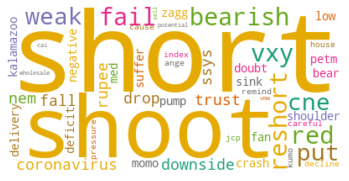

In [71]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=[], background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
#plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(vocab[neg_inds])))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")    
plt.show()

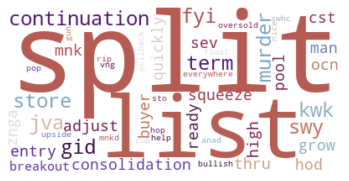

In [72]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=[], background_color="white", colormap="twilight_shifted",
               max_font_size=150, random_state=42)
#plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(vocab[pos_inds])))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")    
plt.show()

In [73]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB().fit(train_data, train_labels)
nb_preds_test = nb_clf.predict(test_data)
nb_errs_test = np.sum((nb_preds_test > 0.0) != (test_labels > 0.0))
print("Test error: ", float(nb_errs_test)/len(test_labels))

Test error:  0.342


In [74]:
print(nb_clf.predict_proba(vectorizer.transform(["It is not what like"])))

[[0.22584573 0.77415427]]


In [75]:
print(nb_clf.predict(vectorizer.transform(["Waste of my time"])))

[1]
